# Exploring My Face (Featuring OpenCV)
Yup, let's do that. I just want to take a look at my face in this post. Realistically, I'm wanting to explore image processing, and by processing, I really just mean loading and resizing haha.

My motivation is this: In a regular fully connected NN, each pixel becomes an input of the NN, right? With more inputs comes more compute time because the network gets more complex and the gradient that we are scanning will take longer to calculate (finding the derivative of the linear combinations of the neurons). The MNIST images were 28 x 28. My photos are... well actually I'm not sure yet, let's check it out. It should be way more because I took it with my iPhone, but I'm not quite sure just how much more. I'll load the image and check it out in the next section, but my original point was that the more pixels I have, the longer it should take my NN to train. This, of course, depends on other factors as well like the number of samples we have (we have way less samples here than we do in the MNIST data set), but with all other factors held constant it will take longer to train. I want to avoid training time if I can to optimize my time on AWS, and I think my face can be represented with way less pixels than what the iPhone gives us, so I'll use OpenCV (an image processing library) to load, explore, and resize the image!

## OpenCV
Even though I'm just resizing an image, I do want to explore the OpenCV package a little bit. I'm looking to OpenCV for image processing as what Librosa was for audio processing was when I did my music genre analysis project. Once again, [sentdex](https://pythonprogramming.net/loading-images-python-opencv-tutorial/) has an entire tutorial series on OpenCV... it's got quite a few algorithms up it's sleeve just out of the box...
- Background subtracting
- Color filtering
- Edge detection
- Object recognition

I'm going to use the most complex one of all - Taking a 100 x 100 image and bringing it down to 50 x 50 lol. Actually, I just thought of another application as well. I took the photos in color, but I'm going to convert it over to black and white as well. The reason for this being more for simplicity than anything else. I don't want to complicated my process too much because I have enough to worry about just training the NN.

Let's just take a look at a breakdown of a digital image first. A _**color**_ image is comprised of 3 layers. This is, first off, assuming that we're working in the RGB domain... The RGB domain is able to make up any color using 3 primary colors (hello elementary school!) - Red, Green, and Blue. There exists other domains like CMYK (Cyan, Magenta, Yellow, and Black) or HSL which doesn't even use colors as its basis but uses Hue, Saturation, and Lightness. I won't get into the other color models as that's deviating from the scope a little bit here, so I'll stick with RGB:

<img src="http://www.mobiliodevelopment.com/wp-content/uploads/2012/04/RGB-vs-CMYK.jpg" style="width: 500px;"/>

The image above shows RGB contrasted with CMYK, we see that RGB makes CMYK as its secondary colors. If we're using Red, Gree, and Blue to represent color, how do we actually represent each pixel? Each pixel will theoretically have 3 values representing its true color. If a raw image is 28 x 28 pixels, it will actually have _**three**_ 28 x 28 arrays representing the image. An array of Red values, Green values, and Blue values!

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/45_rgb_layers.png)

Each pixel of each color channel will hold a value between $[0, 255]$ with $0$ being white, $255$ being black, and all other colors being a lighter or darker version of the primary color.

You could imagine that if we actually wanted to train a NN, or any model for that matter, on a color image, we likely would need to flatten each array and concatenate them together to create a single row of inputs:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/46_rgb_layers_flatten.png" style="width: 600px;"/>

This adds a bit more complexity than I would like to deal with at this point (again, all in the name of project scope), so I'm going to use OpenCV to convert the image to a grayscale image as well. This will convert the 3 arrays of R, G, and B to a single array of Gray (with $[0, 255]$ representing various shades of gray.

Let's try loading in one image just for fun.

In [125]:
import cv2
import numpy as np
import urllib
import math
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
# Load a sample image
img_chi = cv2.imread('../photos/chi/IMG_1265.JPG', cv2.IMREAD_GRAYSCALE)

In [70]:
# Define function to convert URL to numpy array
def url_to_image(url):
    # Download the image, convert it to a numpy array, and then read it into OpenCV format
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
 
    # Return the image
    return image

In [71]:
# Load image from URL on S3
img_chi = url_to_image('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/photos/chi/IMG_1265.JPG')

In [72]:
# View dimensions of photo
img_chi.shape

(3024, 3024)

So, to answer my question before, this photo is indeed not 28x28, but 3024x3024 haha, good for

$$\frac{3024\times 3024}{28\times 28}=11664$$

11664 times the number of pixels as each MNIST image. That's a lot of pixels relatively, and I'm wondering if the picture can be downsized by a fraction while still being able to tell that it's my face. I'm hoping yes.

Another thing to note: The _**img**_ variable is in fact a single array. This means that the photo is being represented by a single channel or layer, the **cv2.IMREAD_GRAYSCALE** indicated that it is grayscale.

Let's take a look at my face.

In [73]:
# Show the first 20x20 block of img to take a look at values explicitly
img_chi[:20:20]

array([[181, 182, 182, ..., 194, 191, 190]], dtype=uint8)

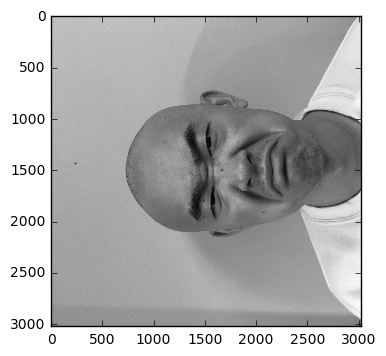

In [74]:
# Show image in matplotlib
plt.imshow(img_chi, cmap='gray')

Beautiful. I clearly chose the right photo to showcase... It's sideways though... I think this has something to do with how the image is being read from the URL... numpy has a [function to rotate an array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.rot90.html), so I'll build that into the function:

In [75]:
# Define function to convert URL to numpy array
def url_to_image(url):
    # Download the image, convert it to a numpy array, and then read it into OpenCV format
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    
    # Rotate image
    image = np.rot90(image, 3)

    # Return the image
    return image

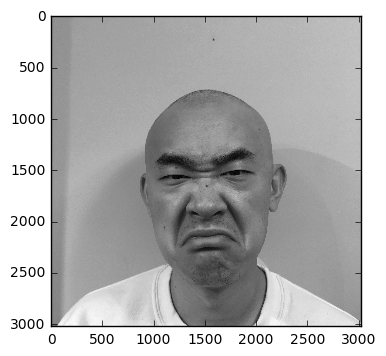

In [76]:
# Load image from URL on S3
img_chi = url_to_image('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/photos/chi/IMG_1265.JPG')

# Show image in matplotlib
plt.imshow(img_chi, cmap='gray')

Beautiful. I think that's the right word here... yeah?

Let's load one of my girlfriend.

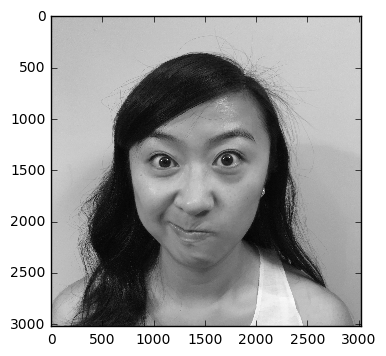

In [77]:
# Load image from URL on S3
img_lars = url_to_image('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/photos/lars/IMG_1128.JPG')

# Show image in matplotlib
plt.imshow(img_lars, cmap='gray')

A few things I tried to keep constant here across the photos of the two of us...
- I tried to keep the background as least intrusive as possible - I took these photos behind a solid cream-colored wall (no pure white walls in my apartment)
- I tried to keep the composition of the frame the same (head centered, head size, shoulder position)
- I tried to keep the lighting the same (consitently lighting from our kitchen throughout)

Whether or not I succeeded here is probably subjective to the eye... There are shadows on the back wall, her head is a bit larger than mine in the frame, the head is not completely centered... etc but I think this is good enough for a first draft to learn from.

## Image Size
We did say that we had a pretty large image relative to the MNIST samples, so let's see if we can use OpenCV to resize the image:

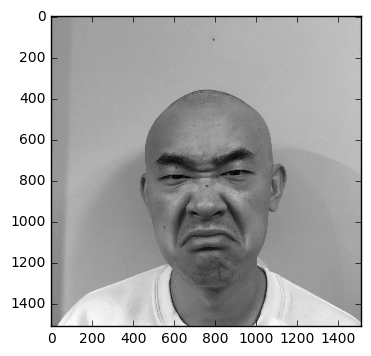

In [82]:
# Resize image by half using cv2's resize()
img_chi_resize = cv2.resize(img_chi, (0,0), fx=0.5, fy=0.5)
plt.imshow(img_chi_resize, cmap='gray')

In [83]:
print 'Resized image has shape {}'.format(img_chi_resize.shape)

Resized image has shape (1512, 1512)


I just want to point out that the _**resize()**_ method has an _**interpolation**_ parameter which can be chosen from the following [resizing methods](http://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html):
- Nearest Neighbour
- Bilinear
- Bicubic
- Area Relation

I'm not claiming to be an expert in any of these, but the top two are quite easy to grasp from this youtube video below from [Computerphile](https://www.youtube.com/channel/UC9-y-6csu5WGm29I7JiwpnA):

[![](http://img.youtube.com/vi/AqscP7rc8_M/0.jpg)](http://www.youtube.com/watch?v=AqscP7rc8_M)

I won't get into it too much, but the _**resize()**_ method, by default, uses the bilinear interpolator which just assumes a linear relationship between two pixels when resizing and fills intermediate pixels in accordingly.

I wonder how low of a resolution we can go before the image becomes unrecognizable in my own eyes.

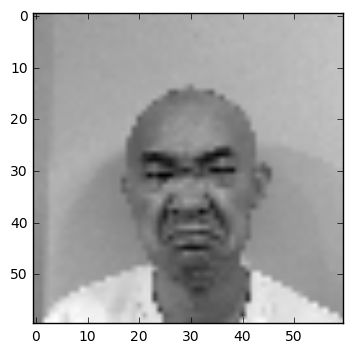

In [96]:
# Resize image by half using cv2's resize()
img_chi_resize = cv2.resize(img_chi, (0,0), fx=0.02, fy=0.02)
plt.imshow(img_chi_resize, cmap='gray')

I'd probably want to do a big better than this... Let's check out a few values in between:

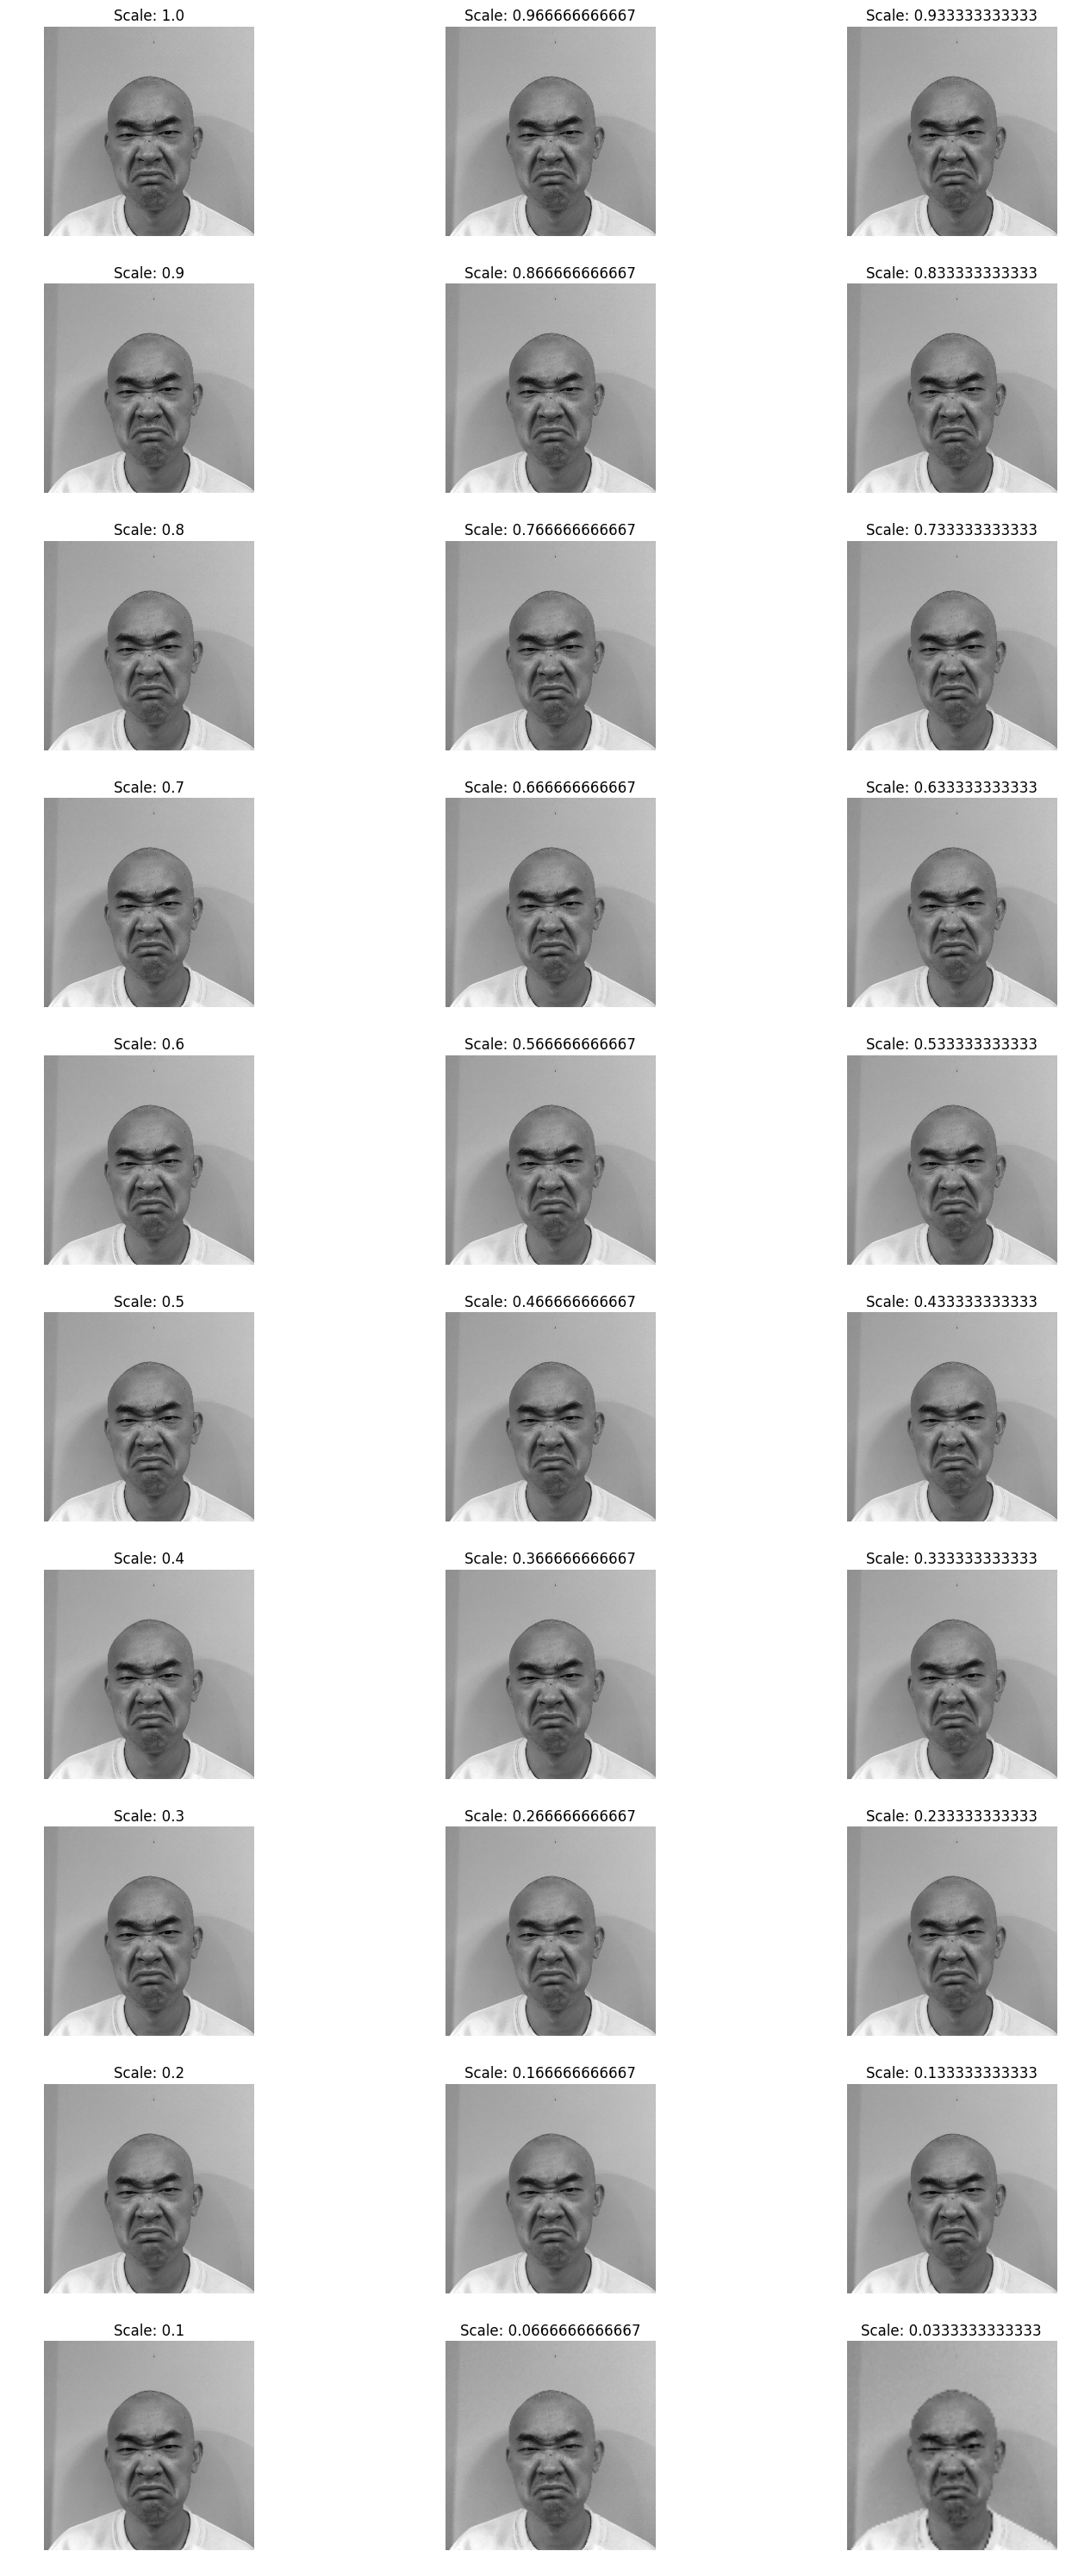

In [116]:
# Iterate and show of image resize and picture quality
images_to_plot = 30
n_cols = 3

fig, ax = plt.subplots(nrows = int(math.ceil(images_to_plot / n_cols)), ncols = n_cols, figsize = (15, 30))

i = 0
for row in ax:
    for col in row:
        resize_proportion = float(1)/float(images_to_plot)
        resize_scale = float(1) - (float(i) * float(resize_proportion))
        
        img_chi_resize = cv2.resize(img_chi, (0,0), fx = resize_scale, fy = resize_scale)
        
        col.set_title('Scale: {}'.format(resize_scale))
        col.imshow(img_chi_resize, cmap='gray')
        col.set_axis_off()
        
        i += 1

plt.tight_layout()
plt.show()

It looks like it doesn't get super grainy until like 0.0333 (the LAST image!). It looks like 0.06 might be a good place to park:

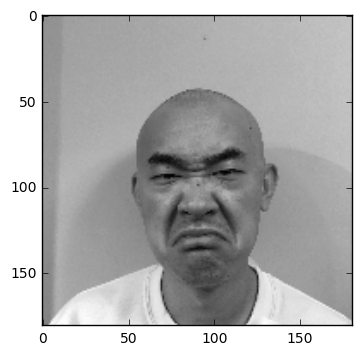

In [119]:
# Resize image by half using cv2's resize()
img_chi_resize = cv2.resize(img_chi, (0,0), fx=0.06, fy=0.06)
plt.imshow(img_chi_resize, cmap='gray')

In [121]:
img_chi_resize.shape

(181, 181)

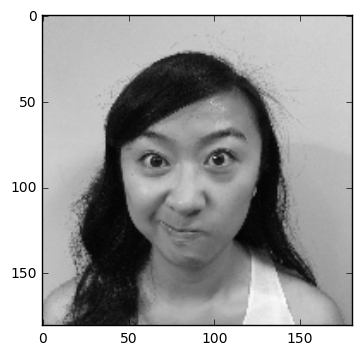

In [120]:
# Resize image by half using cv2's resize()
img_lars_resize = cv2.resize(img_lars, (0,0), fx=0.06, fy=0.06)
plt.imshow(img_lars_resize, cmap='gray')

In [122]:
img_lars_resize.shape

(181, 181)

Good enough for now, I think. We've gotten from 3000ish x 3000ish to 181 x 181! I can probably even run this NN on my own laptop with only ~200 samples of myself and ~200 samples of my girlfriend!

## Training Set
In my training set, again, I tried to keep it simple. I have 400 photos of me and my girlfriend doing normal and weird faces. My hope here is that it will identify our general facial structure so when I test with new pictures, the model will be relatively lenient on our facial expressions. My guess thinking back now is that other factors will probably matter way more... the hair and that shadow on the left hand side of my photo may matter more than any faces we make, and in fact, I'd say the hair will probably take the cake for most of the decisions at the end of the day (it's quite the contrast), but it'll be fun to play around with testing different faces and backgrounds to see which factors really affect the decision making process.

I just wanted to showcase some of the faces (key word _**showcase**_) so we can get a sense of what kinds of inputs the NN will be seeing.

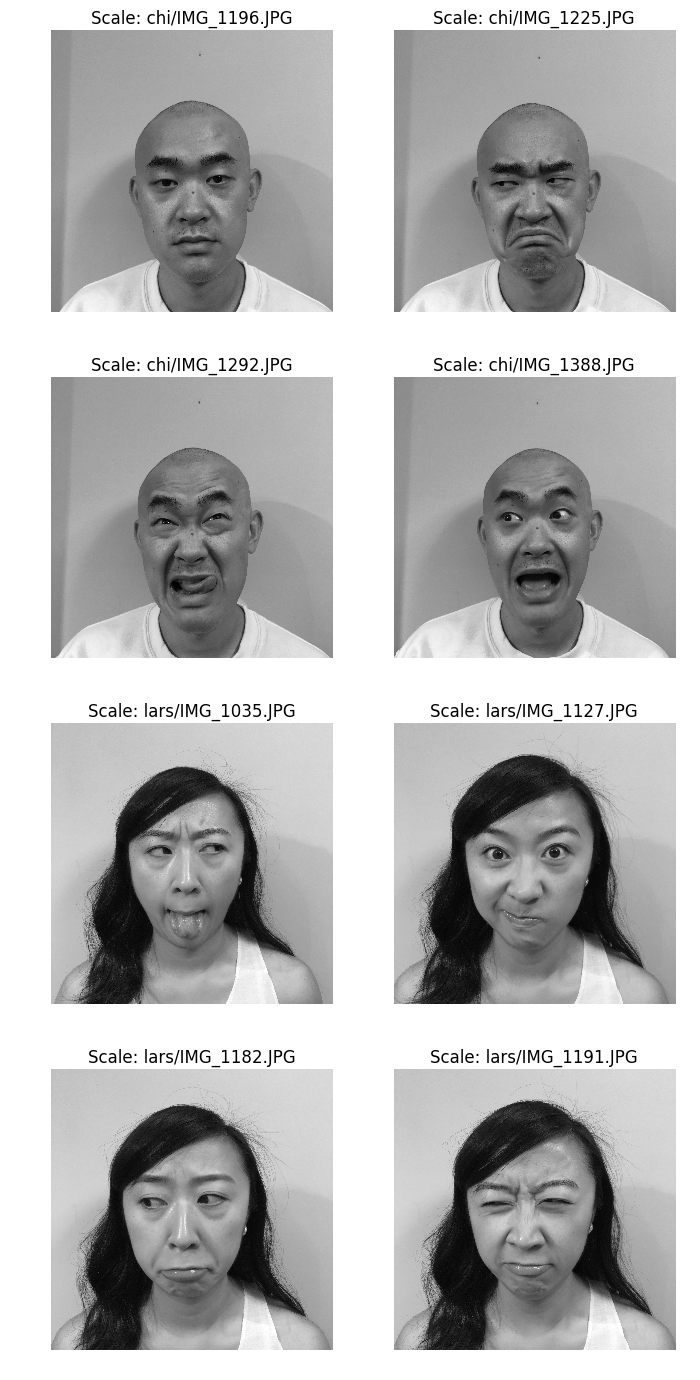

In [130]:
# Iterate and show of image resize and picture quality
images_to_plot = 8
n_cols = 2

url_prefix = 'https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/photos/'

training_samples = [
    'chi/IMG_1196.JPG',
    'chi/IMG_1225.JPG',
    'chi/IMG_1292.JPG',
    'chi/IMG_1388.JPG',
    'lars/IMG_1035.JPG',
    'lars/IMG_1127.JPG',
    'lars/IMG_1182.JPG',
    'lars/IMG_1191.JPG'
]

fig, ax = plt.subplots(nrows = int(math.ceil(images_to_plot / n_cols)), ncols = n_cols, figsize = (7, 14))

i = 0
for row in ax:
    for col in row:
        image = url_to_image(os.path.join(url_prefix, training_samples[i]))
        col.set_title('Scale: {}'.format(training_samples[i]))
        col.imshow(image, cmap='gray')
        col.set_axis_off()
        
        i += 1

plt.tight_layout()
plt.show()

That's probably good for this post - I will continue to build my NN in the next!